## Naive bayes and attack
We assume each pixel is a feature, and they are independent of each other

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from scipy import optimize
from numpy import log, exp
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from numpy import pi
import torch.distributions as D

In [2]:
from numpy.random import permutation
import eagerpy as ep
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import warnings

warnings.filterwarnings('ignore')

## 0. load the data

In [4]:
# binarize for torch tensors
def binarization_torch(picture_set):
    picture_set_out = (picture_set >= 0.5).to(torch.float64)
    return picture_set_out

def binarization_numpy(picture_set):
    picture_set[picture_set>=0.5] =1
    picture_set[picture_set<0.5] =0
    return picture_set 


In [6]:
mnist_train = datasets.MNIST(
    root='/Users/jw733991/Documents/nus_/Jan2020/5340/project/mnist-data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(
    root='/Users/jw733991/Documents/nus_/Jan2020/5340/project/mnist-data/', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(mnist_train, batch_size=len(mnist_train))
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test))


X_train =next(iter(train_loader))[0]
X_train = binarization_torch(X_train)
X_train = X_train.numpy()
X_test = next(iter(test_loader))[0]
X_test = binarization_torch(X_test)
X_test = X_test.numpy()

y_train =next(iter(train_loader))[1].numpy()
y_test = next(iter(test_loader))[1].numpy()

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# permutate it
# perm_train = permutation(X_train.shape[0])
# perm_test = permutation(X_test.shape[0])
# X_train_torch = torch.from_numpy(X_train[perm_train][:]).float()
# y_train_torch = torch.from_numpy(y_train[perm_train][:]).float()
# X_test_torch = torch.from_numpy(X_test[perm_test][:]).float()
# y_test_torch = torch.from_numpy(y_test[perm_test][:]).float()

X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()


y_classes = np.unique(y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(f'Y Class Labels: {y_classes}')

print(X_train_torch.shape)
print(y_train.shape)


(60000, 784)
(10000, 784)
(60000,)
(10000,)
Y Class Labels: [0 1 2 3 4 5 6 7 8 9]
torch.Size([60000, 784])
(60000,)


## 1. Learn/Train Naive Bayes parameters (mean and variance)

### 1.1 approach one: directly calculate from closed form MLE solution

In [7]:
closed_form_means = np.zeros((10,784))
closed_form_vars = np.zeros((10,784))
closed_form_priors = np.zeros((10))

X_subsets = []
for cls in y_classes:
    print(f'Processing Y Class: {cls}')
    X_subsets.append(X_train[y_train==cls])
# X_subsets = np.asarray(X_subsets)
# print(X_subsets.shape)

for cls in y_classes:
    x_subset = X_subsets[cls]
    print(x_subset.shape)
    closed_form_priors[cls] += x_subset.shape[0]
    
#     closed_form_priors.append(x_subset.shape[0])
#     closed_form_mean_one_class = x_subset.mean(axis=0)
#     aaaa = np.mean(x_subset, axis=0)
#     print("for one class, the mean shape is {}, should be 784".format(aaaa.shape))
    closed_form_means[cls] = np.mean(x_subset, axis=0)
          
    bbbb = np.sqrt(np.var(x_subset, axis=0))
    print("for one class, the std shape is {}, should be 784".format(bbbb.shape))
    closed_form_vars[cls] = np.var(x_subset, axis=0)
    
closed_form_vars += 1e-9 # add a small value so later the log pdf won't go infinite
closed_form_priors = np.array(closed_form_priors)/y_train.shape[0]
print("{} {} {}".format(closed_form_means.shape, closed_form_vars.shape, closed_form_priors.shape))


Processing Y Class: 0
Processing Y Class: 1
Processing Y Class: 2
Processing Y Class: 3
Processing Y Class: 4
Processing Y Class: 5
Processing Y Class: 6
Processing Y Class: 7
Processing Y Class: 8
Processing Y Class: 9
(5923, 784)
for one class, the std shape is (784,), should be 784
(6742, 784)
for one class, the std shape is (784,), should be 784
(5958, 784)
for one class, the std shape is (784,), should be 784
(6131, 784)
for one class, the std shape is (784,), should be 784
(5842, 784)
for one class, the std shape is (784,), should be 784
(5421, 784)
for one class, the std shape is (784,), should be 784
(5918, 784)
for one class, the std shape is (784,), should be 784
(6265, 784)
for one class, the std shape is (784,), should be 784
(5851, 784)
for one class, the std shape is (784,), should be 784
(5949, 784)
for one class, the std shape is (784,), should be 784
(10, 784) (10, 784) (10,)


### 1.2 approach 2, sklearn optimizer which optimize negative log likelihood

In [8]:
def negloglike(theta, x):
    mu = theta[0]
    var = theta[1]
    # setup lower bound for the variance
    limit = 1e-6    
    if var < limit:
        var = limit
    N = x.size
    nll = N*log(var) + np.sum((x - mu)**2/var)
    return nll

def fit_distribution(x):
    feature_mean = np.mean(x)
    feature_var = np.var(x)
    bnds = ((None, None), (0, None))
    params = optimize.minimize(negloglike, np.array([feature_mean, feature_var]), 
                               args=(x), bounds=bnds, tol=1e-10, method='BFGS')
    opt_mean = params.x[0]
    opt_std = np.sqrt(params.x[1]) # convert variance to std dev
    dist = norm(opt_mean, opt_std)
    return dist, opt_mean, np.power(opt_std,2)

def optimizer_learn_for_param(X_train, y_classes):
    X_subsets = []
    for cls in y_classes:
        print(f'Processing Y Class: {cls}')
    #     this_x = X[y==cls]
        X_subsets.append(X_train[y_train==cls])
    X_subsets = np.asarray(X_subsets)
    print(X_subsets.shape)
    
    cls_col_dist_list = []
    opt_mean_list = []
    opt_vars_list = []
    for cls in y_classes:
        # OK, since y classes are 0 and 1, so use it as the index
        print(f'Processing Y Class: {cls}')
        x_subset = X_subsets[cls]
        print(x_subset.shape)

        # For each column, create a normal distribution and put in the list
        col_dist_list = np.array([fit_distribution(x_subset[:, i])[0] for i in range(x_subset.shape[1])])
        cls_col_dist_list.append(col_dist_list)

        class_mean_list = np.array([fit_distribution(x_subset[:, i])[1] for i in range(x_subset.shape[1])])
        class_var_list = np.array([fit_distribution(x_subset[:, i])[2] for i in range(x_subset.shape[1])])

        opt_mean_list.append(class_mean_list)
        opt_vars_list.append(class_var_list)
        print("here the opt_mean size is {} (should be 784), opt_variance size is {} (should be 784)".format(class_mean_list.shape, class_var_list.shape))

    cls_col_dist_list = np.array(cls_col_dist_list)
    print("cls_col_dist_list shape {}, should be 10*784".format(cls_col_dist_list.shape))
    opt_mean_list = np.array(opt_mean_list)
    print("mean vector shape {}, should be 10*784".format(opt_mean_list.shape))
    opt_vars_list = np.array(opt_vars_list)
    opt_vars_list += 1e-9  # add a small value so later the log pdf won't go infinite
    print("var vector shape {}, should be 10*784".format(opt_vars_list.shape))
    
    return opt_mean_list, opt_vars_list

opt_mean_list, opt_vars_list = optimizer_learn_for_param(X_train, y_classes)
print("{} {}".format(opt_mean_list.shape, opt_vars_list.shape))


Processing Y Class: 0
Processing Y Class: 1
Processing Y Class: 2
Processing Y Class: 3
Processing Y Class: 4
Processing Y Class: 5
Processing Y Class: 6
Processing Y Class: 7
Processing Y Class: 8
Processing Y Class: 9
(10,)
Processing Y Class: 0
(5923, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Processing Y Class: 1
(6742, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Processing Y Class: 2
(5958, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Processing Y Class: 3
(6131, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Processing Y Class: 4
(5842, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Processing Y Class: 5
(5421, 784)
here the opt_mean size is (784,) (should be 784), opt_variance size is (784,) (should be 784)
Proces

## 2. Setup the Naive Bayes model in torch

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [27]:
class NaiveBayes(torch.nn.Module):
    def __init__(self, features_size, classes_size, y_classes): # featuresize=784, classesize=10
        super().__init__()
        self.features_size = features_size
        self.classes_size = classes_size
        self.y_classes = y_classes

    def fit_sklearn_Gaussian(self, X, y):
        X_np = X.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()
        self.sklearn_g_NB = GaussianNB().fit(X_np, y_np)

        self.means = torch.from_numpy(self.sklearn_g_NB.theta_).to(device=device) # shape (10, 784), mean of each feature
        self.vars = torch.from_numpy(self.sklearn_g_NB.sigma_).to(device=device) # shape (10, 784), variance for each feature
          
    def apply_customized_params(self, means, variances):
        self.means=means
        self.vars=variances
    
    def straight_through_estimator(self, x): 
        x_hard = torch.zeros_like(x)
        x_hard[x>=0.5] = 1
        x = x_hard + x - x.detach()
        return x
    
    def forward(self, X):
        X = X.reshape(X.shape[0], -1)
        X = self.straight_through_estimator(X)
        y_likelihood_all = self.predict_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_all = softmax(y_likelihood_all)
        return softmax_all.T

    def predict(self, X):
        X = X.reshape(X.shape[0], -1)
        y_likelihood_all = self.predict_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_all = softmax(y_likelihood_all)
        result = self.y_classes[torch.argmax(softmax_all, axis=0)]
        return result
    
    def predict_likelihood(self, X):
        likelihood_all = torch.empty((self.y_classes.shape[0], X.shape[0])).to(device=device)
        for i in range(self.y_classes.shape[0]):
            GaussianDistribution = D.Normal(self.means[i,:], self.vars[i,:]) 
            log_likelihood_list = GaussianDistribution.log_prob(X)
            log_likelihood_list = torch.sum(log_likelihood_list,-1) 
            likelihood_all[i] = log_likelihood_list
        return likelihood_all
    

model = NaiveBayes(784, 10, y_classes).to(device)
print(model) # expecting NaiveBayes()
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

NaiveBayes()


## 2. Test the model

### 2.1 try the parameters from default sklearn Gaussian NB, train and check the baseline accuracy

1) try the sklearn case
If we directly try the sklearn-fit, the accuracy will be really low like 54%. However during my implementation, I found it should be their code issue.\
For GaussianNB, sigma_ by what they mentioned, is variance, however seems that's the square of variance. If I use sqrt(sigma_) as a parameter of our own Naive Bayes torch class, then the accuracy (72.67%) is higher than the default sklearn fit function(56%) . Normally it shouldn't really affect. However our pixel is in range of 0-1, and variance is small, and for those elements whose variance is 0 (which is also common in our dataset), sklearn seems to add a small number like 2e-10 to it, and that migh also introduce difference

<class 'numpy.ndarray'>
Accuracy: 72.25%


<AxesSubplot:>

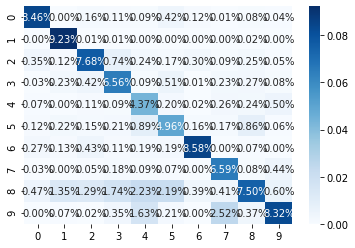

In [28]:
gnb_clf_torch = NaiveBayes(X_train.shape[1], len(y_classes), y_classes ).to(device=device)
gnb_clf_torch.fit_sklearn_Gaussian(X_train_torch, y_train_torch)
y_pred = gnb_clf_torch.predict(X_test_torch)
print(type(y_pred))

acc = np.sum(y_pred==y_test_torch.numpy())/y_test_torch.shape[0]
print(f'Accuracy: {acc*100:.2f}%')
GNB_matrix = confusion_matrix(y_pred, y_test_torch.numpy())
sns.heatmap(GNB_matrix/np.sum(GNB_matrix), annot=True, fmt='.2%', cmap='Blues')

### 2.2 try the MLE closed form solution case

<class 'numpy.ndarray'>
Accuracy: 72.56%


<AxesSubplot:>

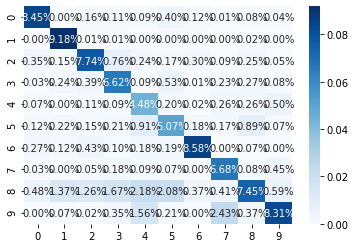

In [29]:
gnb_clf_torch1 = NaiveBayes(X_train.shape[1], len(y_classes), y_classes ).to(device=device)

closed_form_means_torch = torch.from_numpy(closed_form_means).to(device=device)
closed_form_vars_torch = torch.from_numpy(closed_form_vars).to(device=device)

gnb_clf_torch1.apply_customized_params(closed_form_means_torch, closed_form_vars_torch)

y_pred1 = gnb_clf_torch1.predict(X_test_torch)
print(type(y_pred1))

acc = np.sum(y_pred1==y_test_torch.numpy())/y_test_torch.shape[0]
print(f'Accuracy: {acc*100:.2f}%')
GNB_matrix = confusion_matrix(y_pred1, y_test_torch.numpy())
sns.heatmap(GNB_matrix/np.sum(GNB_matrix), annot=True, fmt='.2%', cmap='Blues')


### 2.1 Try the sklearn optimized parameters

<class 'numpy.ndarray'>
Accuracy: 72.56%


<AxesSubplot:>

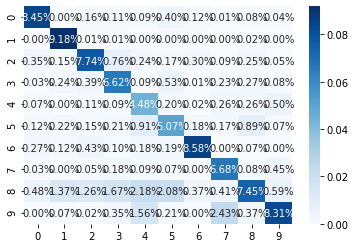

In [30]:
gnb_clf_torch2 = NaiveBayes(X_train_torch.shape[1], len(y_classes), y_classes).to(device=device)

opt_mean_torch = torch.from_numpy(opt_mean_list).to(device=device)
opt_vars_torch = torch.from_numpy(opt_vars_list).to(device=device)

gnb_clf_torch2.apply_customized_params(opt_mean_torch, opt_vars_torch)
y_pred2 = gnb_clf_torch2.predict(X_test_torch)
print(type(y_pred2))

acc = np.sum(y_pred2==y_test_torch.numpy())/y_test_torch.shape[0]
print(f'Accuracy: {acc*100:.2f}%')
GNB_matrix = confusion_matrix(y_pred2, y_test_torch.numpy())
sns.heatmap(GNB_matrix/np.sum(GNB_matrix), annot=True, fmt='.2%', cmap='Blues')

## 3. Perform attack on the naive bayes

In [15]:
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import matplotlib.pyplot as plt
import time

In [16]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(24, 24))

    for i, ax in enumerate(axs.flat):
        image = images[i]
        image = np.squeeze(image, axis=0)
        ax.matshow(image)
        ax.axis('off')
        ax.set_title(f'Image {i}')

### 3.1 attack against the model returned from step 2.2

In [46]:
model = gnb_clf_torch1.eval()
fmodel = PyTorchModel(model, bounds=(0, 1))
batch_size = 20
images, labels = samples(fmodel, dataset="mnist", batchsize=batch_size)

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
# plot_images(images.cpu().numpy())
print("labels     : ", [l for l in labels.cpu().numpy()])
print("predictions: ", [l for l in predictions.cpu().numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 8, 9, 4, 9, 0, 6, 9, 0, 1, 0, 9, 7, 2, 8]
clean accuracy:  75.0 %


epsilons
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
Time taken:  0.003629755973815918 seconds
Clipped adversaries: 


{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
Time taken:  0.0031171679496765138 seconds
Clipped adversaries: 


{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.8  0.75 0.75 0.75 0.75]
Time taken:  0.09225579500198364 seconds
Clipped adversaries: 


{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=N

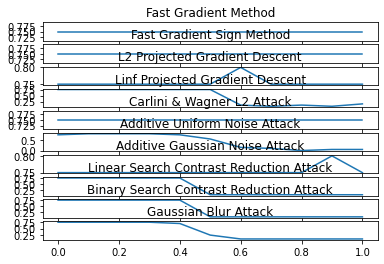

In [47]:
%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},

        # decision-based attacks
#            {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
#         0.0005,
#         0.001,
#         0.0015,
#         0.002,
#         0.003,
#         0.005,
#         0.01,
#         0.02,
#         0.03,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=bool)
fig, axs = plt.subplots(len(attacks))
fig.tight_layout()
for i, attack in enumerate(attacks):
    # plot_images(images.cpu().numpy())
    # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
    # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
    # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
    t1 = time.time()
    raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
    t2 = time.time()
    success_ = is_adv.cpu().numpy()
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("Time taken: ", (t2 - t1) / batch_size, "seconds")

    # plot the robust accuracy against epsilons for the particular attack
    robust_accuracy = 1 - is_adv.float().mean(axis=-1)
    axs[i].plot(epsilons, robust_accuracy.cpu().numpy())
    axs[i].set_title(attack["name"])
    # axs.plot(epsilons, robust_accuracy.cpu().numpy())
    # axs.set_title(attack["name"])

    print("Clipped adversaries: \n\n")
    # plot_images(clipped_adv[0].cpu().numpy())


### 3.2  attack against the model returned from step 2.3

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 8, 9, 4, 9, 0, 6, 9, 0, 1, 0, 9, 7, 2, 8]
clean accuracy:  75.0 %


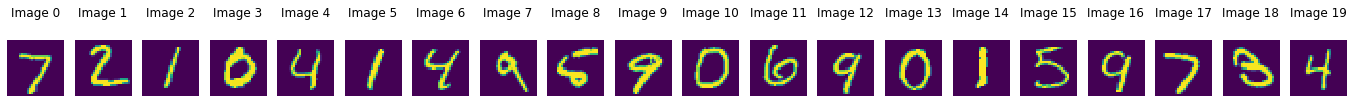

In [48]:
model = gnb_clf_torch2.eval()
fmodel = PyTorchModel(model, bounds=(0, 1))
batch_size = 20
images, labels = samples(fmodel, dataset="mnist", batchsize=batch_size)

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
plot_images(images.cpu().numpy())
print("labels     : ", [l for l in labels.cpu().numpy()])
print("predictions: ", [l for l in predictions.cpu().numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75]
Time taken:  0.005768489837646484 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75]
Time taken:  0.005084562301635742 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.8  0.75 0.8 ]
Time t

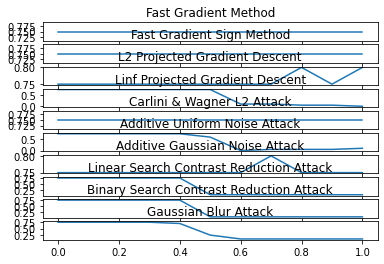

In [49]:
%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},

        # decision-based attacks
#            {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
        0.0005,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.005,
        0.01,
        0.02,
        0.03,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=bool)
fig, axs = plt.subplots(len(attacks))
fig.tight_layout()
for i, attack in enumerate(attacks):
    # plot_images(images.cpu().numpy())
    # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
    # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
    # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
    t1 = time.time()
    raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
    t2 = time.time()
    success_ = is_adv.cpu().numpy()
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("Time taken: ", (t2 - t1) / batch_size, "seconds")

    # plot the robust accuracy against epsilons for the particular attack
    robust_accuracy = 1 - is_adv.float().mean(axis=-1)
    axs[i].plot(epsilons, robust_accuracy.cpu().numpy())
    axs[i].set_title(attack["name"])
    # axs.plot(epsilons, robust_accuracy.cpu().numpy())
    # axs.set_title(attack["name"])

    print("Clipped adversaries: ")
    # plot_images(clipped_adv[0].cpu().numpy())
